In [2]:
import json
import pandas as pd

tweets = []

with open('/kaggle/input/dataset/tweets_DM.json', 'r') as file:
    for line in file:
        try:
            json_data = json.loads(line)  
            tweet = json_data.get('_source', {}).get('tweet', {})
            text = tweet.get('text', None)
            tweet_id = tweet.get('tweet_id', None)
            if text:
                tweets.append({"tweet_id": tweet_id, "text": text})
        except json.JSONDecodeError as e:
            print(f"Error decoding line: {e}")

df_tweets = pd.DataFrame(tweets)

print(df_tweets)

         tweet_id                                               text
0        0x376b20  People who post "add me on #Snapchat" must be ...
1        0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2        0x28b412  Confident of your obedience, I write to you, k...
3        0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4        0x2de201  "Trust is not the same as faith. A friend is s...
...           ...                                                ...
1867530  0x316b80  When you buy the last 2 tickets remaining for ...
1867531  0x29d0cb  I swear all this hard work gone pay off one da...
1867532  0x2a6a4f  @Parcel2Go no card left when I wasn't in so I ...
1867533  0x24faed  Ah, corporate life, where you can date <LH> us...
1867534  0x34be8c             Blessed to be living #Sundayvibes <LH>

[1867535 rows x 2 columns]


In [3]:
df_id = pd.read_csv('/kaggle/input/dataset/data_identification.csv')
df_id_tweets = pd.merge(df_tweets, df_id, on='tweet_id', how='left')

print(df_id_tweets)

         tweet_id                                               text  \
0        0x376b20  People who post "add me on #Snapchat" must be ...   
1        0x2d5350  @brianklaas As we see, Trump is dangerous to #...   
2        0x28b412  Confident of your obedience, I write to you, k...   
3        0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>   
4        0x2de201  "Trust is not the same as faith. A friend is s...   
...           ...                                                ...   
1867530  0x316b80  When you buy the last 2 tickets remaining for ...   
1867531  0x29d0cb  I swear all this hard work gone pay off one da...   
1867532  0x2a6a4f  @Parcel2Go no card left when I wasn't in so I ...   
1867533  0x24faed  Ah, corporate life, where you can date <LH> us...   
1867534  0x34be8c             Blessed to be living #Sundayvibes <LH>   

        identification  
0                train  
1                train  
2                 test  
3                train  
4         

In [4]:
df_emo = pd.read_csv('/kaggle/input/dataset/emotion.csv')
df_train = df_id_tweets[df_id_tweets['identification'] == 'train']
df_test = df_id_tweets[df_id_tweets['identification'] == 'test']

df_train_emo = pd.merge(df_train, df_emo, on='tweet_id', how='left')

print(df_train_emo)
print(df_test)

         tweet_id                                               text  \
0        0x376b20  People who post "add me on #Snapchat" must be ...   
1        0x2d5350  @brianklaas As we see, Trump is dangerous to #...   
2        0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>   
3        0x1d755c  @RISKshow @TheKevinAllison Thx for the BEST TI...   
4        0x2c91a8       Still waiting on those supplies Liscus. <LH>   
...           ...                                                ...   
1455558  0x321566  I'm SO HAPPY!!! #NoWonder the name of this sho...   
1455559  0x38959e  In every circumtance I'd like to be thankful t...   
1455560  0x2cbca6  there's currently two girls walking around the...   
1455561  0x24faed  Ah, corporate life, where you can date <LH> us...   
1455562  0x34be8c             Blessed to be living #Sundayvibes <LH>   

        identification       emotion  
0                train  anticipation  
1                train       sadness  
2                t

In [5]:
df_train_emo.to_pickle("train_emo.pkl") 
df_test.to_pickle("test.pkl")

In [6]:
train_df = pd.read_pickle("train_emo.pkl")
test_df = pd.read_pickle("test.pkl")

In [6]:
train_df.groupby(['emotion']).count()['tweet_id']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: tweet_id, dtype: int64

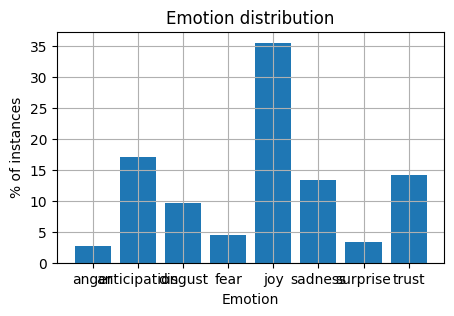

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['tweet_id']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

# Note: it is clear that there is a class imbalance problem 
# This will be accounted for during model training for better performance

In [8]:
train_df.head()

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [24]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd  
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.tokenize import TweetTokenizer 
from nltk.corpus import words 
import re  
import emoji  
import nltk  

nltk.download('punkt') 
nltk.download('words')
english_vocab = set(words.words())

def is_emoji(token):
    return any(char in emoji.EMOJI_DATA for char in token)

tokenizer = TweetTokenizer()

def tokenize_tweet(tweet):
    # Tokenize the tweet
    tokens = tokenizer.tokenize(tweet)
    filtered_tokens = [
        token for token in tokens
        if re.match(r'^[A-Za-z0-9]+$', token) and token.lower() in english_vocab
        or is_emoji(token)
    ]
    return filtered_tokens

tfidf = TfidfVectorizer(tokenizer=tokenize_tweet, stop_words='english')

X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])

print(f"Train data TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test data TF-IDF shape: {X_test_tfidf.shape}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train data TF-IDF shape: (1455563, 32340)
Test data TF-IDF shape: (411972, 32340)


In [8]:
# cleaned tokens are mainly actual words & emojis -> relevant for emotions
feature_names = tfidf.get_feature_names_out()
print(feature_names[500:600])
print(feature_names[32200:32300])

['afterwork' 'afterworld' 'aga' 'agama' 'agape' 'agar' 'agarwal' 'age'
 'aged' 'agee' 'ageless' 'agen' 'agency' 'agenda' 'agent' 'ager'
 'aggrandize' 'aggrandizement' 'aggrandizer' 'aggravate' 'aggravating'
 'aggravation' 'aggregate' 'aggregation' 'aggregator' 'aggress'
 'aggression' 'aggressive' 'aggressively' 'aggressiveness' 'aggressor'
 'aggrieved' 'agha' 'aghast' 'agile' 'agility' 'aging' 'agitate'
 'agitation' 'agitator' 'aglow' 'agnostic' 'ago' 'agog' 'agon' 'agonize'
 'agonizingly' 'agony' 'agora' 'agoraphobia' 'agouti' 'agrarian' 'agree'
 'agreeability' 'agreeable' 'agreed' 'agreeing' 'agreement' 'agricultural'
 'agriculture' 'agrimony' 'agronomy' 'agua' 'aguacate' 'aguinaldo'
 'aguish' 'agust' 'agy' 'ah' 'aha' 'ahead' 'ahem' 'ahimsa' 'ahluwalia'
 'ahoy' 'ahsan' 'ai' 'aid' 'aide' 'aiel' 'ailing' 'ailment' 'aim' 'aiming'
 'aimless' 'aimlessly' 'aint' 'air' 'airbrush' 'aircraft' 'aircrew'
 'airdrop' 'aire' 'airfield' 'airhead' 'airing' 'airlift' 'airliner'
 'airmail' 'airman']
[

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
import numpy as np

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)

X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

sample_size = 50000 
sample_indices = np.random.choice(X_train_tfidf_reduced.shape[0], size=sample_size, replace=False)

X_train_sampled = X_train_tfidf_reduced[sample_indices]
y_train_sampled = train_df['emotion'].iloc[sample_indices]

class_weights = compute_class_weight(class_weight='balanced', 
                                      classes=np.unique(y_train_sampled), 
                                      y=y_train_sampled)
class_weight_dict = dict(zip(np.unique(y_train_sampled), class_weights))

dt_model = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42)
dt_model.fit(X_train_sampled, y_train_sampled)

y_pred = dt_model.predict(X_test_tfidf_reduced)
test_df['predicted_emotion'] = y_pred
print(test_df.head())

    tweet_id                                               text  \
2   0x28b412  Confident of your obedience, I write to you, k...   
4   0x2de201  "Trust is not the same as faith. A friend is s...   
9   0x218443  When do you have enough ? When are you satisfi...   
30  0x2939d5  God woke you up, now chase the day #GodsPlan #...   
33  0x26289a  In these tough times, who do YOU turn to as yo...   

   identification predicted_emotion  
2            test               joy  
4            test               joy  
9            test           sadness  
30           test               joy  
33           test      anticipation  


In [10]:
print(test_df)

         tweet_id                                               text  \
2        0x28b412  Confident of your obedience, I write to you, k...   
4        0x2de201  "Trust is not the same as faith. A friend is s...   
9        0x218443  When do you have enough ? When are you satisfi...   
30       0x2939d5  God woke you up, now chase the day #GodsPlan #...   
33       0x26289a  In these tough times, who do YOU turn to as yo...   
...           ...                                                ...   
1867525  0x2913b4  "For this is the message that ye heard from th...   
1867529  0x2a980e  "There is a lad here, which hath five barley l...   
1867530  0x316b80  When you buy the last 2 tickets remaining for ...   
1867531  0x29d0cb  I swear all this hard work gone pay off one da...   
1867532  0x2a6a4f  @Parcel2Go no card left when I wasn't in so I ...   

        identification predicted_emotion  
2                 test               joy  
4                 test               joy  
9     

In [11]:
submission_df = test_df.rename(columns={'tweet_id': 'id', 'predicted_emotion': 'emotion'})

submission_df = submission_df[['id', 'emotion']]

submission_df.to_csv('Submissions.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

n_components = 750  
svd = TruncatedSVD(n_components=n_components, random_state=42)

X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

sample_size = 100000  
sample_indices = np.random.choice(X_train_tfidf_reduced.shape[0], size=sample_size, replace=False)

X_train_sampled = X_train_tfidf_reduced[sample_indices]
y_train_sampled = train_df['emotion'].iloc[sample_indices]

class_weights = compute_class_weight(class_weight='balanced', 
                                      classes=np.unique(y_train_sampled), 
                                      y=y_train_sampled)
class_weight_dict = dict(zip(np.unique(y_train_sampled), class_weights))

ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, use_label_encoder=False))
], voting='hard')

ensemble_model.fit(X_train_sampled, y_train_sampled)

y_pred_ensemble = ensemble_model.predict(X_test_tfidf_reduced)

test_df['predicted_emotion'] = y_pred_ensemble
test_df[['tweet_id', 'predicted_emotion']].rename(columns={'tweet_id': 'id'}).to_csv('Submissions_ensemble.csv', index=False)

print(test_df)

In [10]:
ens = test_df.rename(columns={'tweet_id': 'id', 'predicted_emotion': 'emotion'})

ens = ens[['id', 'emotion']]

ens.to_csv('Submissions2.csv', index=False)

In [11]:
print(ens)

               id       emotion
2        0x28b412  anticipation
4        0x2de201  anticipation
9        0x218443       sadness
30       0x2939d5           joy
33       0x26289a  anticipation
...           ...           ...
1867525  0x2913b4           joy
1867529  0x2a980e  anticipation
1867530  0x316b80      surprise
1867531  0x29d0cb         anger
1867532  0x2a6a4f       disgust

[411972 rows x 2 columns]
